# Verifying the SpeechT5 model

I needed to do the following to be able to load the original model:

- Clone the https://github.com/microsoft/SpeechT5 repo

Install stuff:

```
pip install editdistance
pip install -U sacrebleu==1.5.1

git submodule update --init SpeechT5/fairseq
cd SpeechT5
pip install --editable fairseq/
pip install espnet
```

Put this notebook at the same level as the `SpeechT5` repo.

Hack the code:

- Copy `speecht5/tasks/speecht5.py` into `fairseq/fairseq/tasks`

- To run on CPU: In `speecht5/sequence_generator.py`, comment out where it does `.to(device="cuda")`

Additional stuff to download:

- `dict.txt` from https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK

- `tokenizer` from https://drive.google.com/uc?export=download&id=1wClgQjXXoU2lmpbaEa1v2SqMbg7cAutq

- `speecht5_base_asr.pt` and `t5_transformer_lm.pt` from https://huggingface.co/ajyy/SpeechT5

You also need an input audio file, any WAV at 16 kHz will do.

In [1]:
%reload_ext autoreload
%autoreload 2

Set Python path so it can find the `speecht5` and `fairseq` modules.

In [2]:
import sys
sys.path.insert(0, "../SpeechT5/SpeechT5")
sys.path.insert(0, "../SpeechT5/SpeechT5/fairseq")

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

## Load audio and preprocess

In [4]:
input_file = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/1272/141231/1272-141231-0020.flac"

In [5]:
input_file = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/AUDIO_DIR/dev_clean/1272/128104/1272-128104-0000.flac"

In [6]:
import soundfile as sf
wav_data, cur_sample_rate = sf.read(input_file)
wav_data.shape, cur_sample_rate

((93680,), 16000)

NOTE: The `Wav2Vec2FeatureExtractor` does not make sure the audio file is mono. If it has shape `(2, length)` or even `(1, length)` then the output from the feature extractor is incorrect!

The `do_normalize` option is False for the SpeechT5 ASR model.

In [7]:
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(do_normalize=False, return_attention_mask=True)

In [8]:
inputs = feature_extractor(wav_data, sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs["input_values"].shape

torch.Size([1, 93680])

In [9]:
# for testing padding mask
inputs["attention_mask"][:, 40000:] = 0

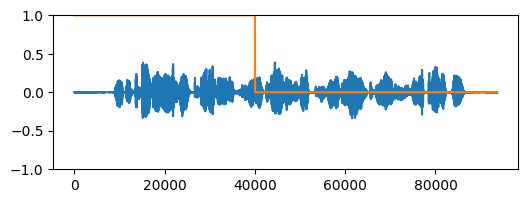

In [10]:
plt.figure(figsize=(6, 2))
plt.plot(inputs["input_values"][0])
plt.plot(inputs["attention_mask"][0])
plt.ylim(-1, 1)
plt.show()

Transform multiple inputs into a single padded batch:

In [11]:
input_file2 = "/Users/matthijs/Documents/FILES/HuggingFace/S2S/textless/AUDIO_DIR/selfdestruct.wav"
wav_data2, cur_sample_rate2 = sf.read(input_file2)
wav_data2.shape, cur_sample_rate2

((128632,), 16000)

In [12]:
inputs2 = feature_extractor([wav_data, wav_data2], sampling_rate=cur_sample_rate, padding=True, return_tensors="pt")
inputs2["input_values"].shape

torch.Size([2, 128632])

The original model used a `padding_mask` as input, where False means no padding. The `Wav2Vec2FeatureExtractor` can return an `attention_mask`, where 1 means no padding.

In [13]:
inputs2["attention_mask"]

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)

In [228]:
inputs = inputs2   # use the batch

## Load the Transformers model

To convert the original checkpoint weights to Transformers:

First download the checkpoint. I used `speecht5_base_asr.pt` from https://huggingface.co/ajyy/SpeechT5

Then run the following, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task s2t \
  --checkpoint_path /path/to/SpeechT5/speecht5_base_asr.pt 
  --pytorch_dump_folder_path /some/other/path
```

In [15]:
from transformers import (
    SpeechT5Config, 
    SpeechT5CTCTokenizer,
    SpeechT5Processor,
    SpeechT5Model, 
    SpeechT5ForConditionalGeneration, 
    SpeechT5ForCTC, 
    Wav2Vec2FeatureExtractor,
)

In [16]:
config = SpeechT5Config()
hf_model = SpeechT5Model(config)

In [17]:
model_checkpoint = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr"

Note that loading should work OK for both the base class `SpeechT5Model` and `SpeechT5ForCTC`.

In [18]:
hf_model = SpeechT5ForConditionalGeneration.from_pretrained(model_checkpoint)

In [19]:
hf_model.eval()

SpeechT5ForConditionalGeneration(
  (speecht5): SpeechT5Model(
    (encoder): SpeechT5SpeechEncoder(
      (prenet): SpeechT5SpeechEncoderPrenet(
        (feature_encoder): SpeechT5FeatureEncoder(
          (conv_layers): ModuleList(
            (0): SpeechT5GroupNormConvLayer(
              (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (activation): GELUActivation()
              (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
            )
            (1): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (2): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (activation): GELUActivation()
            )
            (3): SpeechT5NoLayerNormConvLayer(
              (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
    

In [33]:
hf_model_naked = SpeechT5Model.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at /Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr were not used when initializing SpeechT5Model: ['speecht5.encoder.wrapped_encoder.layers.11.attention.v_proj.bias', 'speecht5.decoder.wrapped_decoder.layers.1.feed_forward.output_dense.weight', 'speecht5.encoder.wrapped_encoder.layers.6.feed_forward.intermediate_dense.weight', 'speecht5.encoder.wrapped_encoder.layers.9.attention.q_proj.bias', 'speecht5.decoder.wrapped_decoder.layers.3.self_attn_layer_norm.weight', 'speecht5.encoder.wrapped_encoder.layers.9.feed_forward.output_dense.bias', 'speecht5.decoder.prenet.embed_tokens.weight', 'speecht5.encoder.wrapped_encoder.layers.5.attention.q_proj.weight', 'speecht5.decoder.wrapped_decoder.layers.3.final_layer_norm.weight', 'speecht5.encoder.wrapped_encoder.layers.8.final_layer_norm.weight', 'speecht5.encoder.wrapped_encoder.layers.10.attention.q_proj.bias', 'speecht5.decoder.wrapped_decoder.layers.2.encoder_attn_layer_nor

Some weights of SpeechT5Model were not initialized from the model checkpoint at /Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_asr and are newly initialized: ['speecht5.encoder.layers.1.feed_forward.intermediate_dense.weight', 'speecht5.decoder.layers.5.feed_forward.intermediate_dense.weight', 'speecht5.encoder.layers.4.attention.v_proj.weight', 'speecht5.encoder.layers.5.attention.k_proj.weight', 'speecht5.encoder.layers.2.attention.out_proj.weight', 'speecht5.decoder.layers.2.self_attn.v_proj.weight', 'speecht5.encoder.layers.8.final_layer_norm.weight', 'speecht5.decoder.layers.3.encoder_attn.q_proj.bias', 'speecht5.encoder.layers.3.attention.k_proj.weight', 'speecht5.encoder.layers.0.final_layer_norm.bias', 'speecht5.decoder.layers.0.encoder_attn.k_proj.bias', 'speecht5.encoder.layers.6.attention.q_proj.weight', 'speecht5.encoder.layers.7.attention.k_proj.bias', 'speecht5.encoder.layers.10.feed_forward.intermediate_dense.weight', 'speecht5.encoder.layers.

In [351]:
# Verify the attention layer weights are correct
# for i in range(len(hf_model.speecht5.encoder.layers)):
#     print(i, "k_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.k_proj.weight == orig_model.encoder.layers[i].self_attn.k_proj.weight))
#     print(i, "k_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.k_proj.bias == orig_model.encoder.layers[i].self_attn.k_proj.bias))
#     print(i, "v_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.v_proj.weight == orig_model.encoder.layers[i].self_attn.v_proj.weight))
#     print(i, "v_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.v_proj.bias == orig_model.encoder.layers[i].self_attn.v_proj.bias))
#     print(i, "q_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.q_proj.weight == orig_model.encoder.layers[i].self_attn.q_proj.weight))
#     print(i, "q_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.q_proj.bias == orig_model.encoder.layers[i].self_attn.q_proj.bias))
#     print(i, "out_proj weight", torch.all(hf_model.speecht5.encoder.layers[i].attention.out_proj.weight == orig_model.encoder.layers[i].self_attn.out_proj.weight))
#     print(i, "out_proj bias", torch.all(hf_model.speecht5.encoder.layers[i].attention.out_proj.bias == orig_model.encoder.layers[i].self_attn.out_proj.bias))
#     print("---")

# print("pos_emb weight", torch.all(hf_model.speecht5.encoder.pos_emb.pe_k.weight == orig_model.encoder.pos_emb.pe_k.weight))

Run a single forward pass. This should run the encoder, decoder, and the relevant pre- and postnets.

In [20]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.prenet(**inputs)

type(hf_outputs)

tuple

In [21]:
# Using no attention_mask
# with torch.no_grad():
#      hf_outputs = hf_model.speech_encoder_prenet(input_values=inputs["input_values"])

# type(hf_outputs)

In [22]:
# list(hf_outputs.keys())

In [23]:
# hf_outputs["extract_features"].shape

In [24]:
# hf_outputs["extract_features"]

In [25]:
# hf_outputs["hidden_states"].shape

In [26]:
# hf_outputs["hidden_states"]

In [27]:
[x.shape for x in hf_outputs if hasattr(x, "shape")]

[torch.Size([2, 401, 768]), torch.Size([2, 401])]

In [28]:
hf_outputs[0]

tensor([[[ 6.9419e+00,  6.0887e+00,  5.0580e+00,  ...,  5.8203e-01,
           2.5973e+00, -1.8086e-01],
         [ 7.1978e+00,  1.6047e+00,  9.1351e+00,  ...,  1.2387e+00,
           2.8825e+00,  3.4502e+00],
         [ 3.0047e+00, -7.6195e-01,  1.1497e+01,  ...,  1.3287e+00,
           2.6715e+00,  2.3741e+00],
         ...,
         [-1.2140e-01, -9.2100e-02, -1.5428e-01,  ..., -2.4324e-01,
          -2.2983e-01, -2.0718e-01],
         [ 4.0435e-02, -9.1658e-02, -1.5430e-01,  ..., -2.5205e-01,
          -2.0630e-01, -2.5674e-01],
         [ 8.2007e-03, -1.3189e-01, -1.6461e-01,  ..., -2.0494e-01,
          -3.0676e-01, -3.1394e-01]],

        [[ 1.4333e+00, -1.8173e+00,  9.1156e-01,  ...,  7.4279e-01,
          -3.9927e-01,  1.0221e+00],
         [ 5.6487e-01, -2.0062e+00,  2.2312e-02,  ...,  6.6407e-01,
           9.8154e-02,  1.4818e+00],
         [-2.7547e-01, -2.7482e+00, -7.6423e-01,  ...,  4.7994e-01,
           2.4423e-01,  1.1358e+00],
         ...,
         [ 1.2788e-01, -1

In [29]:
hf_encoder_input = hf_outputs[0]
hf_encoder_attention_mask = hf_outputs[1]

## Load the original model

Load the dictionary. This adds `<s>, <pad>, </s>, <unk>` tokens to the front and `<mask>` and `<ctc_blank>` to the end. **dict.txt** was [downloaded from here](https://drive.google.com/uc?export=download&id=19hcQ58RHZ6CssxF8Qp6yEF1NW_AXxObK). This is the Vocabulary link from the main SpeechT5 README.

In [30]:
from fairseq.data import Dictionary
tgt_dict = Dictionary.load("/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/DATA_ROOT/dict.txt")
tgt_dict.add_symbol("<mask>")
tgt_dict.add_symbol("<ctc_blank>")
print(f"dictionary size: " f"{len(tgt_dict):,}")

dictionary size: 81


To load the model we need the `SpeechT5Task` object but constructing it is annoying. Fortunately, `build_model` only reads two properties from the task object, so we can fake it.

In [31]:
class FakeTask:
    def __init__(self):
        self.dicts = { "text": tgt_dict }
        self.t5_task = "s2t"
        
task = FakeTask()

Load the fine-tuned ASR model.

In [32]:
import torch
from speecht5.models.speecht5 import T5TransformerModel

In [33]:
checkpoint = torch.load("../weights/SpeechT5/speecht5_base_asr.pt")

orig_model = T5TransformerModel.build_model(checkpoint["cfg"]["model"], task)

orig_model.load_state_dict(checkpoint["model"])
orig_model = orig_model.eval()

In [34]:
type(orig_model)

speecht5.models.speecht5.T5TransformerModel

In [35]:
type(orig_model.encoder)

speecht5.models.modules.encoder.TransformerEncoder

In [36]:
#list(checkpoint["model"].keys())

In [37]:
from fairseq.data import encoders
from argparse import Namespace
tokenizer = encoders.build_bpe(
    Namespace(
        bpe='sentencepiece', 
        sentencepiece_model='/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/tryout/MODEL_DIR/spm_char.model'
    )
)
type(tokenizer)

fairseq.data.encoders.sentencepiece_bpe.SentencepieceBPE

In [38]:
# orig_model.decoder.layers[0].encoder_attn

## Verify speech encoder prenet output

This first uses the `speech_encoder_prenet` to convert the raw audio data into embeddings of shape `(batch, sequence_length, 768)`. The sequence length is roughly `number of audio samples / 320`, so there is one vector every 20 ms.

In [39]:
source = inputs["input_values"]
source.shape

torch.Size([2, 128632])

In [40]:
padding_mask = torch.BoolTensor(source.shape).fill_(False)

In [41]:
padding_mask = torch.BoolTensor((1 - inputs["attention_mask"]).bool())
padding_mask

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False]])

In [42]:
# This doesn't work on the original model
#padding_mask = None

In [43]:
encoder_input, encoder_padding_mask = orig_model.speech_encoder_prenet(
    source, padding_mask=padding_mask, mask=False
)

In [44]:
# encoder_input = orig_model.speech_encoder_prenet.feature_extractor(source)
# encoder_input.shape

In [45]:
encoder_input.shape, encoder_padding_mask.shape

(torch.Size([2, 401, 768]), torch.Size([2, 401]))

In [46]:
encoder_input

tensor([[[ 6.9419e+00,  6.0887e+00,  5.0580e+00,  ...,  5.8203e-01,
           2.5973e+00, -1.8086e-01],
         [ 7.1978e+00,  1.6047e+00,  9.1351e+00,  ...,  1.2387e+00,
           2.8825e+00,  3.4502e+00],
         [ 3.0047e+00, -7.6195e-01,  1.1497e+01,  ...,  1.3287e+00,
           2.6715e+00,  2.3741e+00],
         ...,
         [-1.2140e-01, -9.2100e-02, -1.5428e-01,  ..., -2.4324e-01,
          -2.2983e-01, -2.0718e-01],
         [ 4.0435e-02, -9.1658e-02, -1.5430e-01,  ..., -2.5205e-01,
          -2.0630e-01, -2.5674e-01],
         [ 8.2007e-03, -1.3189e-01, -1.6461e-01,  ..., -2.0494e-01,
          -3.0676e-01, -3.1394e-01]],

        [[ 1.4333e+00, -1.8173e+00,  9.1156e-01,  ...,  7.4279e-01,
          -3.9927e-01,  1.0221e+00],
         [ 5.6487e-01, -2.0062e+00,  2.2312e-02,  ...,  6.6407e-01,
           9.8154e-02,  1.4818e+00],
         [-2.7547e-01, -2.7482e+00, -7.6423e-01,  ...,  4.7994e-01,
           2.4423e-01,  1.1358e+00],
         ...,
         [ 1.2788e-01, -1

In [47]:
#encoder_padding_mask

If the weights and model were converted correctly, this should report zero or a very small number:

In [48]:
# torch.max(torch.abs(encoder_input - hf_outputs["hidden_states"]))
torch.max(torch.abs(encoder_input - hf_outputs[0]))

tensor(1.0000)

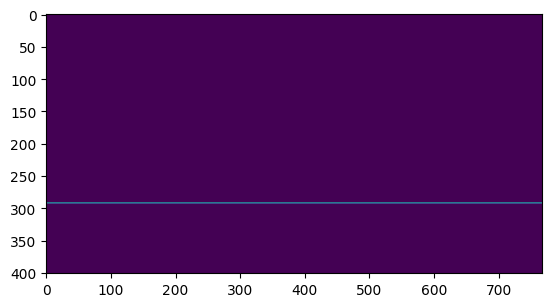

In [52]:
# plt.imshow(torch.abs(encoder_input - hf_outputs["hidden_states"]).numpy()[0] > 1e-5)
plt.imshow(torch.abs(encoder_input - hf_outputs[0]).numpy()[0] > 1e-5)

The line that is different is where the padding mask goes from 1 to 0; the original model handles this a little different than we do.

In [53]:
# torch.max(torch.abs(encoder_input - hf_outputs["extract_features"]))

In [54]:
# torch.abs(encoder_input - hf_outputs["last_hidden_state"])

## Verify Transformer encoder output

In [55]:
# Run it with the original's speech prenet input:
# with torch.no_grad():
#     encoder_output = orig_model.encoder(encoder_input, encoder_padding_mask)

In [112]:
# Run it with our input, which is slightly different (see above)
with torch.no_grad():
    encoder_output = orig_model.encoder(hf_encoder_input, ~hf_encoder_attention_mask)

In [113]:
print("encoder_out shape", encoder_output["encoder_out"][0].shape)
print("encoder_padding_mask shape", encoder_output["encoder_padding_mask"][0].shape)
print("encoder_states", encoder_output["encoder_states"])  # []
print("src_tokens", encoder_output["src_tokens"])  # []
print("decoder_input", encoder_output["decoder_input"])  # [None]
print("encoder_out_for_ctc shape", encoder_output["encoder_out_for_ctc"][0].shape)

encoder_out shape torch.Size([401, 2, 768])
encoder_padding_mask shape torch.Size([2, 401])
encoder_states []
src_tokens []
decoder_input [None]
encoder_out_for_ctc shape torch.Size([401, 2, 81])


In [58]:
encoder_output["encoder_out"][0].permute((1, 0, 2))

tensor([[[-0.3491, -0.0853, -0.4962,  ...,  0.2933, -0.6834,  0.0838],
         [-0.2567, -0.0870, -0.5613,  ...,  0.2358, -0.6816,  0.0205],
         [-0.3327, -0.1112, -0.6037,  ...,  0.2785, -0.6297, -0.1314],
         ...,
         [-0.0580, -0.3146, -0.0368,  ..., -0.2898, -0.1898,  0.2105],
         [-0.2231, -0.3032,  0.0296,  ...,  0.0974, -0.2742,  0.1361],
         [-0.1851, -0.3024,  0.0322,  ...,  0.1357, -0.2357,  0.0736]],

        [[-0.2545, -0.2163, -0.4848,  ...,  0.3813, -0.5618,  0.3422],
         [-0.1782, -0.2388, -0.4575,  ...,  0.3282, -0.5424,  0.2551],
         [-0.1515, -0.3072, -0.3812,  ...,  0.2877, -0.4253,  0.1172],
         ...,
         [ 0.5395,  0.1442, -0.0540,  ...,  0.3096, -0.5798,  0.3530],
         [ 0.2973,  0.0378, -0.0507,  ...,  0.2811, -0.5635,  0.2517],
         [ 0.1936, -0.1404, -0.1436,  ...,  0.3061, -0.5138,  0.1664]]])

In [59]:
encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2))

tensor([[[ -9.7539,  -9.9639,  -9.7654,  ...,  -9.7121,  -9.6935,  13.1617],
         [-10.2644, -10.4033, -10.2593,  ..., -10.2150, -10.2457,  14.2349],
         [-11.2071, -11.2572, -11.2052,  ..., -11.2506, -11.1760,  15.3922],
         ...,
         [-13.4234, -14.0800, -13.6217,  ..., -13.8993, -13.3328,   8.9910],
         [ -9.9343, -10.3540, -10.0413,  ..., -10.0725,  -9.6708,   9.4658],
         [ -9.1374,  -9.5370,  -9.2425,  ...,  -9.2380,  -8.8825,   8.8501]],

        [[ -9.9849, -10.1272, -10.0026,  ..., -10.0058,  -9.7552,  12.7793],
         [-10.4426, -10.5391, -10.4868,  ..., -10.5314, -10.2572,  13.7857],
         [-12.3113, -12.4078, -12.2937,  ..., -12.4932, -12.1741,  15.2556],
         ...,
         [ -9.1622,  -9.3113,  -9.2084,  ...,  -9.3590,  -9.0228,  11.5350],
         [ -9.9882, -10.2963,  -9.9973,  ..., -10.0581,  -9.7548,  11.7940],
         [-10.3344, -10.8017, -10.4995,  ..., -10.4289,  -9.9483,  10.9756]]])

In [60]:
# Use exact same inputs as the original model:
# with torch.no_grad():
#      hf_outputs = hf_model.speecht5(
#          inputs_embeds=encoder_input,
#          attention_mask=(~encoder_padding_mask),
#      )

# type(hf_outputs)

In [61]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.encoder.wrapped_encoder(
         hidden_states=hf_encoder_input,
         attention_mask=hf_encoder_attention_mask,
#          input_values=inputs.input_values,
#          attention_mask=inputs.attention_mask,
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutput

In [62]:
hf_outputs

BaseModelOutput(last_hidden_state=tensor([[[-0.3491, -0.0853, -0.4962,  ...,  0.2933, -0.6834,  0.0838],
         [-0.2567, -0.0870, -0.5613,  ...,  0.2358, -0.6816,  0.0205],
         [-0.3327, -0.1112, -0.6037,  ...,  0.2785, -0.6297, -0.1314],
         ...,
         [-0.0580, -0.3146, -0.0368,  ..., -0.2898, -0.1898,  0.2105],
         [-0.2231, -0.3032,  0.0296,  ...,  0.0974, -0.2742,  0.1361],
         [-0.1851, -0.3024,  0.0322,  ...,  0.1357, -0.2357,  0.0736]],

        [[-0.2545, -0.2163, -0.4848,  ...,  0.3813, -0.5618,  0.3422],
         [-0.1782, -0.2388, -0.4575,  ...,  0.3282, -0.5424,  0.2551],
         [-0.1515, -0.3072, -0.3812,  ...,  0.2877, -0.4253,  0.1172],
         ...,
         [ 0.5395,  0.1442, -0.0540,  ...,  0.3096, -0.5798,  0.3530],
         [ 0.2973,  0.0378, -0.0507,  ...,  0.2811, -0.5635,  0.2517],
         [ 0.1936, -0.1404, -0.1436,  ...,  0.3061, -0.5138,  0.1664]]]), hidden_states=None, attentions=None)

In [63]:
list(hf_outputs.keys())

['last_hidden_state']

In [64]:
hf_outputs["last_hidden_state"].shape

torch.Size([2, 401, 768])

In [65]:
hf_outputs["last_hidden_state"]

tensor([[[-0.3491, -0.0853, -0.4962,  ...,  0.2933, -0.6834,  0.0838],
         [-0.2567, -0.0870, -0.5613,  ...,  0.2358, -0.6816,  0.0205],
         [-0.3327, -0.1112, -0.6037,  ...,  0.2785, -0.6297, -0.1314],
         ...,
         [-0.0580, -0.3146, -0.0368,  ..., -0.2898, -0.1898,  0.2105],
         [-0.2231, -0.3032,  0.0296,  ...,  0.0974, -0.2742,  0.1361],
         [-0.1851, -0.3024,  0.0322,  ...,  0.1357, -0.2357,  0.0736]],

        [[-0.2545, -0.2163, -0.4848,  ...,  0.3813, -0.5618,  0.3422],
         [-0.1782, -0.2388, -0.4575,  ...,  0.3282, -0.5424,  0.2551],
         [-0.1515, -0.3072, -0.3812,  ...,  0.2877, -0.4253,  0.1172],
         ...,
         [ 0.5395,  0.1442, -0.0540,  ...,  0.3096, -0.5798,  0.3530],
         [ 0.2973,  0.0378, -0.0507,  ...,  0.2811, -0.5635,  0.2517],
         [ 0.1936, -0.1404, -0.1436,  ...,  0.3061, -0.5138,  0.1664]]])

In [66]:
torch.max(torch.abs(encoder_output["encoder_out"][0].permute((1, 0, 2)) - hf_outputs["last_hidden_state"]))

tensor(1.9073e-06)

## Verify CTC model

This model only needs the encoder portion.

This uses the same checkpoint as before: `speecht5_base_asr.pt` from https://huggingface.co/ajyy/SpeechT5

Run the following to convert, using your own `--checkpoint_path` and `--pytorch_dump_folder_path`:

```nohighlight
cd transformers/src/transformers/models/speecht5

python convert_speecht5_original_pytorch_checkpoint_to_pytorch.py \
  --task ctc \
  --checkpoint_path /path/to/SpeechT5/speecht5_base_asr.pt 
  --pytorch_dump_folder_path /some/other/path
```

In [69]:
# hf_model_ctc = SpeechT5ForCTC(config)

In [67]:
model_checkpoint_ctc = "/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/weights/speecht5_base_ctc"
hf_model_ctc = SpeechT5ForCTC.from_pretrained(model_checkpoint_ctc)

In [68]:
# Not sure if this should work, since SpeechT5ForCTC does not have a speecht5 property...
#hf_model_ctc = SpeechT5Model.from_pretrained(model_checkpoint_ctc)

In [69]:
# Run the full model:
with torch.no_grad():
     hf_outputs = hf_model_ctc(**inputs)

# Run without attention_mask:
# with torch.no_grad():
#     hf_outputs = hf_model_ctc(input_values=inputs["input_values"])

type(hf_outputs)

transformers.modeling_outputs.CausalLMOutput

In [70]:
torch.max(torch.abs(encoder_output["encoder_out_for_ctc"][0].permute((1, 0, 2)) - hf_outputs[0]))

tensor(9.5367e-06)

In [71]:
probs = torch.nn.functional.softmax(hf_outputs[0], dim=-1, dtype=torch.float32)
probs = probs.argmax(dim=-1)

In [72]:
probs

tensor([[80, 80, 80, 80, 80,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4, 18, 18, 10, 10, 80, 12, 12, 80,  6,
         80,  5, 13, 13,  4,  4, 45, 45, 16, 16, 10, 10, 15, 15, 15, 80, 80,  6,
          6, 80,  5, 13, 13, 80, 80,  4,  4, 80, 10, 10, 80, 12, 12,  4,  4,  6,
         11, 11,  5,  5,  4,  4, 80,  7, 24, 80, 80, 24, 80, 80, 80, 80,  8, 12,
         12, 80, 80, 80, 12, 80, 80, 80,  5, 15, 15, 15, 80, 80, 80,  4,  4, 80,
         80,  8, 19, 19,  4,  4,  6, 11, 11,  5,  4,  4, 18, 10, 10, 14, 80, 14,
         14, 15, 15,  5, 80,  4,  4, 17, 17, 15, 15, 80, 80, 80,  7, 12, 12, 12,
         80, 80, 12, 12, 80, 80,  5,  5, 80, 80, 80, 12, 12, 80, 80, 80, 80, 80,
         80,  4,  4,  4, 80,  7,  9,  9, 14, 80,  4,  4, 20, 20,  5,  5,  4,  4,
          7,  7, 13,  5,  5,  4, 21, 21, 15, 15, 80, 80, 80,  7,  7,  7, 80, 80,
         14, 14, 80, 80,  4,  4,  6,  6,  8,  8, 80,  4,  4, 20, 20, 80,  5, 15,
         15, 15, 15, 80, 80,

In [73]:
# print(tgt_dict.string(probs[0]))

In [74]:
for i in range(probs.shape[0]):
    print(tokenizer.decode(tgt_dict.string(probs[i])).replace("<ctc_blank>", ""))

                      mmiissterr  qquuiillltterr  iiss  thhee  appossselll  off  thhe  miidddlle  ccllassssseess   annd  wwee  aaree ggllaaadd  ttoo  wwellllccoomee  hhhiss   ggoosspplll
       sseelllff  ddesssttrruuucct  will ccoommennce in  ffiivee       ffoouurrr      tthhrrreeeee      tttwwoo        onnee  annd   a  hhaaalllff       oonnee  annd  aa  qquuuaarrterr       oonne  annd  a  littttlee bbiitt


Calculate loss:

In [ ]:
with torch.no_grad():
     hf_outputs = hf_model_ctc(
         **inputs, 
         labels=torch.tensor(
           [[ 46, 16, 12,  6,  4,  6, 11, 13, 16, 12,  6,  4,  7,  9, 14,  4,
         24,  7, 13, 13, 22,  4,  7,  9, 14,  4, 27, 10, 17,  6,  8, 13, 22,  4,
          6,  8,  4,  6, 11,  5,  4, 12,  6, 13,  8,  9, 21,  5, 13, ]]
         ),
         output_hidden_states=True,
         return_dict=True,
     )

In [ ]:
hf_outputs.loss

## Verify text decoder prenet

First this calls `text_decoder_prenet`:

In [154]:
batch_size = inputs.input_values.size(0)
beam_size = 5

In [155]:
tokens = torch.tensor([2, 4, 46, 16, 12, 16] * beam_size * batch_size).reshape(beam_size * batch_size, -1)
tokens.shape

torch.Size([10, 6])

In [131]:
# This one has padding (token_id = 1)
tokens = torch.tensor([2, 4, 46, 16, 1, 12] * beam_size * batch_size).reshape(beam_size * batch_size, -1)

In [156]:
with torch.no_grad():
    prev_output_tokens, tgt_mask, incremental_state = orig_model.text_decoder_prenet(tokens, incremental_state=None)

In [157]:
# This returns a sequence length of 1
# with torch.no_grad():
#     prev_output_tokens, tgt_mask, incremental_state = orig_model.text_decoder_prenet(tokens, incremental_state={})

In [158]:
# Note: misleading name; these are not the actual tokens but their embeddings!
prev_output_tokens.shape

torch.Size([10, 6, 768])

In [159]:
tgt_mask

In [160]:
incremental_state

In [161]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.prenet(
         input_ids=tokens,
#          attention_mask=hf_encoder_attention_mask,
#          attention_mask=inputs.attention_mask,
#          past_key_values=[(torch.ones(5, 1, 1), torch.ones(5, 1, 1))],
     )

type(hf_outputs)

tuple

In [162]:
token_embeds_hf, decoder_attention_mask = hf_outputs

In [163]:
token_embeds_hf.shape

torch.Size([10, 6, 768])

In [164]:
torch.max(torch.abs(prev_output_tokens - token_embeds_hf))

tensor(0.)

In [165]:
decoder_attention_mask

## Verify Transformer decoder output

In [166]:
bsz = source.size(0)
new_order = torch.arange(bsz).view(-1, 1).repeat(1, beam_size).view(-1)
encoder_outs = orig_model.encoder.reorder_encoder_out(encoder_output, new_order)

In [167]:
prev_output_tokens

tensor([[[ 1.1074,  1.1042,  1.0387,  ...,  0.9619,  1.0463,  0.8678],
         [ 0.0890,  0.1702,  0.3139,  ...,  0.8629,  0.7833,  0.9348],
         [-0.7402, -0.4274, -0.5774,  ...,  1.3103,  0.5403,  0.7292],
         [-0.8579, -0.9214, -0.9064,  ...,  1.0331,  0.8949,  0.9723],
         [-0.2291, -0.4457, -0.5671,  ...,  0.9991,  0.8768,  0.9128],
         [ 0.7580,  0.5875,  0.4706,  ...,  1.0331,  0.8949,  0.9723]],

        [[ 1.1074,  1.1042,  1.0387,  ...,  0.9619,  1.0463,  0.8678],
         [ 0.0890,  0.1702,  0.3139,  ...,  0.8629,  0.7833,  0.9348],
         [-0.7402, -0.4274, -0.5774,  ...,  1.3103,  0.5403,  0.7292],
         [-0.8579, -0.9214, -0.9064,  ...,  1.0331,  0.8949,  0.9723],
         [-0.2291, -0.4457, -0.5671,  ...,  0.9991,  0.8768,  0.9128],
         [ 0.7580,  0.5875,  0.4706,  ...,  1.0331,  0.8949,  0.9723]],

        [[ 1.1074,  1.1042,  1.0387,  ...,  0.9619,  1.0463,  0.8678],
         [ 0.0890,  0.1702,  0.3139,  ...,  0.8629,  0.7833,  0.9348],
  

In [168]:
with torch.no_grad():
    decoder_output, extra = orig_model.decoder(
        prev_output_tokens,
        tgt_mask,
        encoder_out=encoder_outs,
        incremental_state=incremental_state,
    )

In [169]:
decoder_output.shape

torch.Size([10, 6, 768])

In [170]:
decoder_output

tensor([[[-0.4042, -0.3464, -0.1654,  ..., -0.2053, -0.4237,  0.0788],
         [-0.4293, -0.6809, -1.6442,  ..., -0.3035,  0.1346,  0.0505],
         [ 0.2834, -0.7885, -1.0885,  ...,  0.2483,  0.1978,  0.5294],
         [ 0.7349, -1.1453, -1.6684,  ...,  0.3394,  0.5876, -0.4216],
         [ 0.6584, -1.1614, -0.8039,  ..., -0.5429,  0.5048, -0.2464],
         [ 0.5320, -0.6075, -0.9035,  ...,  0.6435,  0.6379, -0.0853]],

        [[-0.4042, -0.3464, -0.1654,  ..., -0.2053, -0.4237,  0.0788],
         [-0.4293, -0.6809, -1.6442,  ..., -0.3035,  0.1346,  0.0505],
         [ 0.2834, -0.7885, -1.0885,  ...,  0.2483,  0.1978,  0.5294],
         [ 0.7349, -1.1453, -1.6684,  ...,  0.3394,  0.5876, -0.4216],
         [ 0.6584, -1.1614, -0.8039,  ..., -0.5429,  0.5048, -0.2464],
         [ 0.5320, -0.6075, -0.9035,  ...,  0.6435,  0.6379, -0.0853]],

        [[-0.4042, -0.3464, -0.1654,  ..., -0.2053, -0.4237,  0.0788],
         [-0.4293, -0.6809, -1.6442,  ..., -0.3035,  0.1346,  0.0505],
  

In [171]:
#[x.shape for x in extra["attn"]]

In [172]:
#[x.shape for x in extra["inner_states"]]

In [193]:
with torch.no_grad():
     hf_outputs = hf_model.speecht5.decoder.wrapped_decoder(
         hidden_states=prev_output_tokens,
         attention_mask=decoder_attention_mask,
         encoder_hidden_states=encoder_outs["encoder_out"][0].permute((1, 0, 2)),
         encoder_attention_mask=hf_encoder_attention_mask.repeat((1, beam_size)).view(beam_size * batch_size, -1),
         return_dict=True,
     )

type(hf_outputs)

transformers.modeling_outputs.BaseModelOutputWithPastAndCrossAttentions

In [194]:
list(hf_outputs.keys())

['last_hidden_state', 'past_key_values']

In [195]:
hf_outputs["last_hidden_state"].shape

torch.Size([10, 6, 768])

In [196]:
hf_outputs["last_hidden_state"]

tensor([[[-0.4042, -0.3464, -0.1654,  ..., -0.2053, -0.4237,  0.0788],
         [-0.4293, -0.6809, -1.6442,  ..., -0.3035,  0.1346,  0.0505],
         [ 0.2834, -0.7885, -1.0885,  ...,  0.2483,  0.1978,  0.5294],
         [ 0.7349, -1.1453, -1.6684,  ...,  0.3394,  0.5876, -0.4216],
         [ 0.6584, -1.1614, -0.8039,  ..., -0.5429,  0.5048, -0.2464],
         [ 0.5320, -0.6075, -0.9035,  ...,  0.6435,  0.6379, -0.0853]],

        [[-0.4042, -0.3464, -0.1654,  ..., -0.2053, -0.4237,  0.0788],
         [-0.4293, -0.6809, -1.6442,  ..., -0.3035,  0.1346,  0.0505],
         [ 0.2834, -0.7885, -1.0885,  ...,  0.2483,  0.1978,  0.5294],
         [ 0.7349, -1.1453, -1.6684,  ...,  0.3394,  0.5876, -0.4216],
         [ 0.6584, -1.1614, -0.8039,  ..., -0.5429,  0.5048, -0.2464],
         [ 0.5320, -0.6075, -0.9035,  ...,  0.6435,  0.6379, -0.0853]],

        [[-0.4042, -0.3464, -0.1654,  ..., -0.2053, -0.4237,  0.0788],
         [-0.4293, -0.6809, -1.6442,  ..., -0.3035,  0.1346,  0.0505],
  

In [197]:
torch.max(torch.abs(decoder_output - hf_outputs["last_hidden_state"]))

tensor(1.6689e-06)

Close enough! I would rather see 0.0 but this looks like numerical precision differences for 32-bit floats.

## Verify text decoder postnet output

In [198]:
with torch.no_grad():
    lprobs = orig_model.text_decoder_postnet(decoder_output)

In [199]:
lprobs.shape

torch.Size([10, 6, 81])

In [200]:
lprobs[0]

tensor([[-2.4168e+01, -2.2556e+01,  5.4097e-01, -2.2586e+01,  1.7349e+01,
          4.6760e-02,  6.2041e-01, -9.4606e-01, -4.4315e-01, -1.8812e+00,
         -3.9952e-01,  2.1893e-01,  3.9134e-01, -1.3906e+00, -2.2705e+00,
         -1.5500e+00, -1.0440e+00, -2.6232e+00, -7.7046e-01, -4.0442e-02,
          1.1401e+00,  2.4883e-01, -3.7950e+00, -2.2715e+01, -8.6929e-01,
          6.3732e-01, -2.2659e+01, -2.8817e+00, -3.3690e+00, -2.2606e+01,
         -2.2637e+01,  9.3877e-02, -2.2744e+01, -2.2613e+01, -2.2609e+01,
         -2.2670e+01, -2.2651e+01, -5.3913e+00, -2.2602e+01, -2.2722e+01,
         -2.2586e+01, -2.2674e+01, -2.2655e+01, -2.2676e+01, -2.2658e+01,
         -2.4368e+00, -2.3410e+00, -2.2580e+01, -2.2609e+01, -2.2735e+01,
         -2.2613e+01, -2.2698e+01, -2.2605e+01, -2.2590e+01, -2.2633e+01,
         -2.2558e+01, -2.2639e+01, -6.2336e+00, -2.2628e+01, -2.2604e+01,
         -2.2654e+01, -2.2722e+01, -2.2647e+01, -2.2622e+01, -2.2642e+01,
         -2.2666e+01, -2.2624e+01, -2.

In [201]:
with torch.no_grad():
    lprobs_hf = hf_model.text_decoder_postnet(decoder_output)

In [202]:
lprobs_hf.shape

torch.Size([10, 6, 81])

In [203]:
lprobs_hf[0]

tensor([[-2.4168e+01, -2.2556e+01,  5.4097e-01, -2.2586e+01,  1.7349e+01,
          4.6760e-02,  6.2041e-01, -9.4606e-01, -4.4315e-01, -1.8812e+00,
         -3.9952e-01,  2.1893e-01,  3.9134e-01, -1.3906e+00, -2.2705e+00,
         -1.5500e+00, -1.0440e+00, -2.6232e+00, -7.7046e-01, -4.0442e-02,
          1.1401e+00,  2.4883e-01, -3.7950e+00, -2.2715e+01, -8.6929e-01,
          6.3732e-01, -2.2659e+01, -2.8817e+00, -3.3690e+00, -2.2606e+01,
         -2.2637e+01,  9.3877e-02, -2.2744e+01, -2.2613e+01, -2.2609e+01,
         -2.2670e+01, -2.2651e+01, -5.3913e+00, -2.2602e+01, -2.2722e+01,
         -2.2586e+01, -2.2674e+01, -2.2655e+01, -2.2676e+01, -2.2658e+01,
         -2.4368e+00, -2.3410e+00, -2.2580e+01, -2.2609e+01, -2.2735e+01,
         -2.2613e+01, -2.2698e+01, -2.2605e+01, -2.2590e+01, -2.2633e+01,
         -2.2558e+01, -2.2639e+01, -6.2336e+00, -2.2628e+01, -2.2604e+01,
         -2.2654e+01, -2.2722e+01, -2.2647e+01, -2.2622e+01, -2.2642e+01,
         -2.2666e+01, -2.2624e+01, -2.

In [204]:
torch.max(torch.abs(lprobs - lprobs_hf))

tensor(0.)

## Use the `transformers` generator loop:

Run the full model to make sure this doesn't give any errors:

In [207]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         decoder_input_ids=torch.tensor([[3, 4, 5]]),
         #decoder_input_ids=torch.tensor([[3, 4, 5], [2, 2, 2]]),
     )

type(hf_outputs)

transformers.modeling_outputs.Seq2SeqLMOutput

In [208]:
list(hf_outputs.keys())

['logits', 'past_key_values', 'encoder_last_hidden_state']

In [209]:
hf_outputs["logits"].shape

torch.Size([2, 3, 81])

Also calculate loss:

In [211]:
with torch.no_grad():
     hf_outputs = hf_model(
         input_values=inputs.input_values,
         attention_mask=inputs.attention_mask,
         #decoder_input_ids=torch.tensor([[2,  4, 18, 10, 12,  6,  5]]),
         labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13]]),
         #labels=torch.tensor([[4, 18, 10, 12,  6,  5, 13], [4, 18, 10, 12,  6,  5, 13]]),  # batch
     )

type(hf_outputs)

transformers.modeling_outputs.Seq2SeqLMOutput

In [213]:
hf_outputs["logits"].shape

torch.Size([2, 7, 81])

In [212]:
hf_outputs["loss"]

tensor(1.9692)

Generator loop:

In [230]:
inputs.input_values.shape

torch.Size([2, 128632])

In [240]:
hf_outputs = hf_model.generate(inputs.input_values, max_length=100)
# hf_outputs = hf_model.generate(inputs.input_values, num_beams=5, max_length=100) #, bos_token_id=2)
# hf_outputs = hf_model.generate(torch.rand(1, 10000), num_beams=5, max_length=10)

In [241]:
hf_outputs.shape

torch.Size([2, 100])

In [242]:
hf_outputs

tensor([[ 2,  4, 18, 10, 12,  6,  5, 13,  4, 45, 16, 10, 15,  6,  5, 13,  4, 10,
         12,  4,  6, 11,  5,  4,  7, 24,  8, 12,  6, 15,  5,  4,  8, 19,  4,  6,
         11,  5,  4, 18, 10, 14, 14, 15,  5,  4, 17, 15,  7, 12, 12,  5, 12,  4,
          7,  9, 14,  4, 20,  5,  4,  7, 13,  5,  4, 21, 15,  7, 14,  4,  6,  8,
          4, 20,  5, 15, 17,  8, 18,  5,  4, 11, 10, 12,  4, 21,  8, 12, 24,  5,
         15,  2,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 2,  4, 12,  5, 15, 19,  4, 14,  5, 12,  6, 13, 16, 17,  6, 10,  8,  9,
          4, 17,  8, 18, 18,  5,  9, 17,  5,  4, 10,  9,  4, 19, 10, 27,  5,  4,
         19,  8, 16, 13,  4,  6, 11, 13,  5,  5,  4,  6, 20,  8,  4,  8,  9,  5,
          4,  7,  9, 14,  4,  7,  4, 11,  7, 15, 19,  4,  8,  9,  5,  4,  7,  9,
         14,  4,  7,  4, 45, 16,  7, 13,  6,  5, 13,  4,  8,  9,  5,  4,  7,  9,
         14,  4,  7,  4, 15, 10,  6,  6, 15,  5]])

In [243]:
for i in range(hf_outputs.shape[0]):
    print(tgt_dict.string(hf_outputs[i]))
    print(tokenizer.decode(tgt_dict.string(hf_outputs[i])))
    print("")

▁ m i s t e r ▁ q u i l t e r ▁ i s ▁ t h e ▁ a p o s t l e ▁ o f ▁ t h e ▁ m i d d l e ▁ c l a s s e s ▁ a n d ▁ w e ▁ a r e ▁ g l a d ▁ t o ▁ w e l c o m e ▁ h i s ▁ g o s p e l <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
mister quilter is the apostle of the middle classes and we are glad to welcome his gospel<pad><pad><pad><pad><pad><pad><pad><pad>

▁ s e l f ▁ d e s t r u c t i o n ▁ c o m m e n c e ▁ i n ▁ f i v e ▁ f o u r ▁ t h r e e ▁ t w o ▁ o n e ▁ a n d ▁ a ▁ h a l f ▁ o n e ▁ a n d ▁ a ▁ q u a r t e r ▁ o n e ▁ a n d ▁ a ▁ l i t t l e
self destruction commence in five four three two one and a half one and a quarter one and a little



In [244]:
[tgt_dict[x] for x in range(5)]

['<s>', '<pad>', '</s>', '<unk>', '▁']

For comparison, Speech2Text:

In [ ]:
import torch
from transformers import Speech2TextProcessor, Speech2TextForConditionalGeneration

s2t_model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-small-librispeech-asr")
s2t_processor = Speech2TextProcessor.from_pretrained("facebook/s2t-small-librispeech-asr")

In [222]:
from datasets import load_dataset

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

inputs = s2t_processor(
    ds[0]["audio"]["array"], sampling_rate=ds[0]["audio"]["sampling_rate"], return_tensors="pt"
)
input_features = inputs.input_features
input_features.shape

/Users/matthijs/anaconda3/envs/t5/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'dataset_info': token. Will not be supported from version '0.12'.
  warnings.warn(message, FutureWarning)
Reusing dataset librispeech_asr_dummy (/Users/matthijs/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b)


torch.Size([1, 584, 80])

In [223]:
# test batch
# input_features = torch.tile(input_features, dims=(2, 1, 1))
# input_features.shape

torch.Size([2, 584, 80])

In [224]:
generated_ids = s2t_model.generate(inputs=input_features)

transcription = s2t_processor.batch_decode(generated_ids)[0]
transcription

#'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'

/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/transformers/src/transformers/models/speech_to_text/modeling_speech_to_text.py:561: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  input_lengths = (input_lengths - 1) // 2 + 1
/Users/matthijs/Documents/FILES/HuggingFace/SpeechT5/transformers/src/transformers/generation_utils.py:1296: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the 

'mister quilter is the apostle of the middle classes and we are glad to welcome his gospel'

Test other methods:

In [30]:
# BART, Speech2Text, Wav2Vec2 don't have pruning
#hf_model.prune_heads({1: [0, 2], 2: [2,3 ]})

In [27]:
hf_model.get_input_embeddings()

Embedding(100, 768)

In [28]:
hf_model.get_output_embeddings()

Linear(in_features=768, out_features=100, bias=False)

In [25]:
hf_model.resize_token_embeddings(100)

Embedding(100, 768)

In [26]:
hf_model.get_input_embeddings()

Embedding(100, 768)

In [117]:
hf_model.freeze_feature_encoder()

In [118]:
hf_model_ctc.freeze_feature_encoder()

In [119]:
hf_model_naked.freeze_feature_encoder()